In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Poisson3D
problem = Poisson3D()

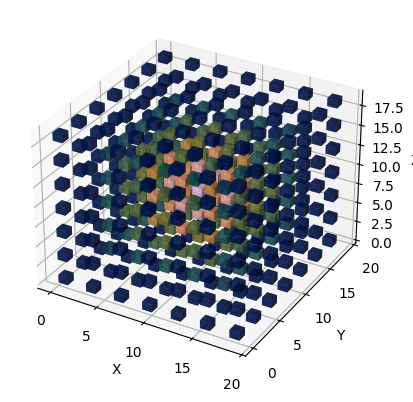

In [3]:
X, Y, Z, u_solution = problem.exact_solution(nx=7, ny=7, nz=7)

def explode(data):
    size = np.array(data.shape)*3
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::3, ::3, ::3] = data
    return data_e

x_num = u_solution.shape[0]
y_num = u_solution.shape[1]
z_num = u_solution.shape[2]
filled = np.ones((x_num, y_num, z_num), dtype=bool)
filled_2 = explode(filled)
values_2 = explode(u_solution)
facecolors_2 = cmap(values_2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.voxels(filled=filled_2, facecolors=facecolors_2, alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [4]:
X, Y, Z, u_solution = problem.exact_solution(nx=32, ny=32, nz=32)

# Optimiser

In [28]:
@partial(jax.jit, static_argnames=("matvec", "rmatvec", "shape", "k"))
def jax_svds(
    matvec: callable,
    rmatvec: callable,
    shape: tuple[int, int],
    k: int,
    key: jax.random.PRNGKey
):
    """
    Computes a truncated SVD using Lanczos bidiagonalization in pure JAX.
    """
    num_rows, num_cols = shape
    
    # 1. Initialization
    v_start = jax.random.normal(key, (num_cols,))
    v_start = v_start / jnp.linalg.norm(v_start)

    V = jnp.zeros((k, num_cols))
    alpha_diag = jnp.zeros(k)
    beta_diag = jnp.zeros(k)

    # 2. The Lanczos iteration loop
    def scan_body(carry, i):
        u_prev, v_curr, alpha_vals, beta_vals, V_acc = carry
        
        v_hat = rmatvec(u_prev) - beta_vals[i-1] * V_acc[i-1]
        alpha_i = jnp.linalg.norm(v_hat)
        v_next = v_hat / alpha_i
        
        u_hat = matvec(v_next) - alpha_i * u_prev
        beta_i = jnp.linalg.norm(u_hat)
        u_next = u_hat / beta_i
        
        alpha_vals = alpha_vals.at[i].set(alpha_i)
        beta_vals = beta_vals.at[i].set(beta_i)
        V_new = V_acc.at[i].set(v_next)
        
        return (u_next, v_next, alpha_vals, beta_vals, V_new), u_next

    u0_hat = matvec(v_start)
    beta0 = jnp.linalg.norm(u0_hat)
    u0 = u0_hat / beta0
    
    initial_carry = (u0, v_start, alpha_diag, beta_diag.at[0].set(beta0), V.at[0].set(v_start))
    (_, _, alpha_final, beta_final, V_final), U_from_scan = jax.lax.scan(
        scan_body, initial_carry, jnp.arange(1, k)
    )
    
    U_final = jnp.vstack([u0, U_from_scan])

    # 3. Form the small bidiagonal matrix B (size k-1 x k-1)
    B = jnp.diag(alpha_final[1:]) + jnp.diag(beta_final[1:-1], k=1)
    
    # 4. Compute SVD of the small matrix B
    Ub, Sb, Vbt = jnp.linalg.svd(B)
    
    # 5. Project back using the correct number of vectors (k-1)
    # THIS IS THE FIX:
    U_approx = U_final[:-1, :].T @ Ub
    V_approx = V_final[:-1, :].T @ Vbt.T

    # Sort in descending order
    return U_approx[:, ::-1], Sb[::-1], V_approx.T[::-1, :]

In [53]:
class HungryLM:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 0.75,
        increase_factor: float = 1.25,
        aggressive_factor: float = 0.75,
        max_trials: int = 20,
        steps_before_aggressive: int = 10,
        required_gain_before_aggressive: float = 0.9,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.aggressive_factor = aggressive_factor
        self.max_trials = max_trials
        self.steps_before_aggressive = steps_before_aggressive
        self.required_gain_before_aggressive = required_gain_before_aggressive

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {
            'lambda': jnp.asarray(self.init_lambda),
            'loss_history': jnp.full((self.steps_before_aggressive,), jnp.inf),
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array],
        key=jax.random.PRNGKey(42)
    ):
        current_lambda = state['lambda']
        loss_history = state["loss_history"]
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)
        
        # --- Update history and get the 'high-water mark' reference loss ---
        new_loss_history = jnp.roll(loss_history, shift=-1).at[-1].set(current_loss)
        reference_loss = jnp.max(new_loss_history)

        J = jax.jacfwd(flat_residual_fn)(params_flat)
        U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
        g = U.T @ residuals

        def _aggressive_step(c_lambda):
            """
            Branch 1: Not enough progress was made.
            """
            trial_lambda = c_lambda / self.decrease_factor * self.aggressive_factor
            delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
            # We "accept" this forced step and report its lambda.
            return True, trial_lambda, delta, 1

        def _regular_lm_search(c_lambda):
            """
            Branch 2: Progress is good.
            """
            def evaluate_trial_step(loop_val):
                _, trial_lambda, _, trial_count = loop_val
                delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
                
                trial_params = eqx.apply_updates(params, unflatten(delta))
                trial_residuals = residual_fn(trial_params)
                trial_loss = jnp.mean(trial_residuals**2)

                accepted = trial_loss < current_loss
                
                # If rejected, increase lambda for the next trial
                new_lambda = jax.lax.cond(
                    accepted,
                    lambda: trial_lambda,
                    lambda: trial_lambda * self.increase_factor
                )
                
                return accepted, new_lambda, delta, trial_count + 1

            def continue_search(loop_val):
                # Continue if step not accepted AND we haven't exceeded max trials
                accepted, _, _, trial_count = loop_val
                return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)
            
            # Run the search loop
            initial_loop_val = (False, c_lambda, jnp.zeros_like(params_flat), 0)
            accepted, final_lambda, final_delta, count = jax.lax.while_loop(
                continue_search, evaluate_trial_step, initial_loop_val
            )
            return accepted, final_lambda, final_delta, count


        not_enough_progress = current_loss > self.required_gain_before_aggressive * reference_loss

        step_was_accepted, final_lambda, lm_delta, trial_count = jax.lax.cond(
            not_enough_progress,
            _aggressive_step,
            _regular_lm_search,
            operand=current_lambda
        )

        updates = unflatten(lm_delta)
        
        new_state = {
            'lambda': final_lambda * self.decrease_factor,
            'loss_history': jax.lax.cond(
                not_enough_progress,
                lambda: jnp.full((self.steps_before_aggressive,), jnp.inf),
                lambda: new_loss_history
            )
        }
        
        metrics = { 
            'loss': current_loss,
            'singular_values': S,
            'search_direction_norm': jnp.linalg.norm(lm_delta),
            'lambda': final_lambda,
        }

        return current_loss, updates, new_state, metrics
    
    
class uHungryLM:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 0.75,
        increase_factor: float = 1.25,
        aggressive_factor: float = 0.75,
        max_trials: int = 20,
        steps_before_aggressive: int = 10,
        required_gain_before_aggressive: float = 0.9,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.aggressive_factor = aggressive_factor
        self.max_trials = max_trials
        self.steps_before_aggressive = steps_before_aggressive
        self.required_gain_before_aggressive = required_gain_before_aggressive

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {
            'lambda': jnp.asarray(self.init_lambda),
            'loss_history': jnp.full((self.steps_before_aggressive,), jnp.inf),
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array],
        key=jax.random.PRNGKey(42)
    ):
        current_lambda = state['lambda']
        loss_history = state["loss_history"]
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)
        new_loss_history = jnp.roll(loss_history, shift=-1).at[-1].set(current_loss)
        reference_loss = jnp.max(new_loss_history)

        num_residuals = residuals.shape[0]
        num_params = params_flat.shape[0]

        def jvp_func(p, v):
            _, res_jvp = jax.jvp(flat_residual_fn, (p,), (v,))
            return res_jvp
        
        def vjp_func(p, v):
            _, vjp_callable = jax.vjp(flat_residual_fn, p)
            return vjp_callable(v)[0]

        matvec = partial(jvp_func, params_flat)
        rmatvec = partial(vjp_func, params_flat)

        residuals = flat_residual_fn(params_flat)
        num_residuals = residuals.shape[0]
        num_params = params_flat.shape[0]

        svd_key, key = jax.random.split(key)

        # --- Call the pure JAX SVD solver ---
        U, S, Vt = jax_svds(
            matvec, rmatvec, shape=(num_residuals, num_params), k=4096, key=svd_key
        )
        
        g = U.T @ residuals


        def _aggressive_step(c_lambda):
            """
            Branch 1: Not enough progress was made.
            """
            trial_lambda = c_lambda / self.decrease_factor * self.aggressive_factor
            delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
            # We "accept" this forced step and report its lambda.
            return True, trial_lambda, delta, 1

        def _regular_lm_search(c_lambda):
            """
            Branch 2: Progress is good.
            """
            def evaluate_trial_step(loop_val):
                _, trial_lambda, _, trial_count = loop_val
                delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
                
                trial_params = eqx.apply_updates(params, unflatten(delta))
                trial_residuals = residual_fn(trial_params)
                trial_loss = jnp.mean(trial_residuals**2)

                accepted = trial_loss < current_loss
                
                # If rejected, increase lambda for the next trial
                new_lambda = jax.lax.cond(
                    accepted,
                    lambda: trial_lambda,
                    lambda: trial_lambda * self.increase_factor
                )
                
                return accepted, new_lambda, delta, trial_count + 1

            def continue_search(loop_val):
                # Continue if step not accepted AND we haven't exceeded max trials
                accepted, _, _, trial_count = loop_val
                return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)
            
            # Run the search loop
            initial_loop_val = (False, c_lambda, jnp.zeros_like(params_flat), 0)
            accepted, final_lambda, final_delta, count = jax.lax.while_loop(
                continue_search, evaluate_trial_step, initial_loop_val
            )
            return accepted, final_lambda, final_delta, count


        not_enough_progress = current_loss > self.required_gain_before_aggressive * reference_loss

        step_was_accepted, final_lambda, lm_delta, trial_count = jax.lax.cond(
            not_enough_progress,
            _aggressive_step,
            _regular_lm_search,
            operand=current_lambda
        )

        updates = unflatten(lm_delta)
        
        new_state = {
            'lambda': final_lambda * self.decrease_factor,
            'loss_history': jax.lax.cond(
                not_enough_progress,
                lambda: jnp.full((self.steps_before_aggressive,), jnp.inf),
                lambda: new_loss_history
            )
        }
        
        metrics = { 
            'loss': current_loss,
            'singular_values': S,
            'search_direction_norm': jnp.linalg.norm(lm_delta),
            'lambda': final_lambda,
            'trial_count': trial_count,
        }

        return current_loss, updates, new_state, metrics
    

@partial(jax.jit, static_argnames=("optimiser", "problem"))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points, key=jax.random.PRNGKey(42)):
    def residual_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        return problem.physics_residual(problem.residual_fn, rebuilt_model, collocation_points)

    loss, updates, new_opt_state, metrics = optimiser.update(params, opt_state, residual_fn_for_optimizer, key=key)
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics

In [57]:
key = jax.random.PRNGKey(42)

layer_sizes = [3, 20, 20, 20, 20, 20, 1]

model_key, data_key = jax.random.split(key)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()

optimiser = HungryLM(
    init_lambda=1e10,
    decrease_factor=0.9,
    increase_factor=1.01,
    aggressive_factor=0.8,
    steps_before_aggressive=200,
    max_trials=200,
    required_gain_before_aggressive=0.75,
)

uoptimiser = uHungryLM(
    init_lambda=1e10,
    decrease_factor=0.9,
    increase_factor=1.01,
    aggressive_factor=0.8,
    steps_before_aggressive=200,
    max_trials=200,
    required_gain_before_aggressive=0.75,
)
opt_state = optimiser.init(params)


collocation_points = problem.get_collocation_points(2**10, seed=1)
ucollocation_points = problem.get_collocation_points(2**13, seed=1)

start_time = time.monotonic()

epoch = 0
for _ in range(20):
    epoch += 1
    
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser, problem, collocation_points
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")

print("using iterative svd")

for _ in range(20):
    epoch += 1
    
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, uoptimiser, problem, ucollocation_points
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")

model = eqx.combine(params, static)
print("Training complete.")

Epoch 5, Loss: 2.911e+02, Time elapsed: 8.33 s
Epoch 10, Loss: 2.751e+02, Time elapsed: 10.87 s
Epoch 15, Loss: 2.512e+02, Time elapsed: 13.64 s
Epoch 20, Loss: 2.188e+02, Time elapsed: 16.16 s
Epoch 25, Loss: 8.911e+05, Time elapsed: 114.73 s


KeyboardInterrupt: 

In [ ]:
u_pred = model.predict(X, Y, Z)

error = jnp.abs(u_solution - u_pred)
rel_l2_error = jnp.linalg.norm(error) / jnp.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

Relative L2 Error: 1.383e-04


In [ ]:
error2 = error[::5, ::5, ::5]
print(error2.shape)

(7, 7, 7)


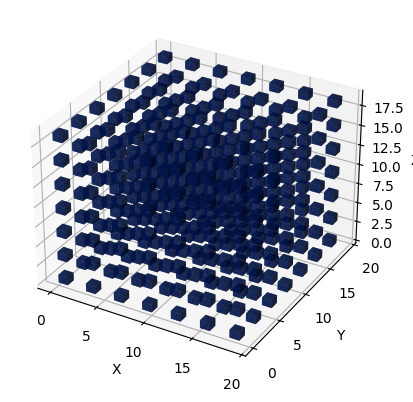

In [ ]:
def explode(data):
    size = np.array(data.shape)*3
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::3, ::3, ::3] = data
    return data_e

x_num = error2.shape[0]
y_num = error2.shape[1]
z_num = error2.shape[2]
filled = np.ones((x_num, y_num, z_num), dtype=bool)
filled_2 = explode(filled)
values_2 = explode(error2)
facecolors_2 = cmap(values_2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.voxels(filled=filled_2, facecolors=facecolors_2, alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

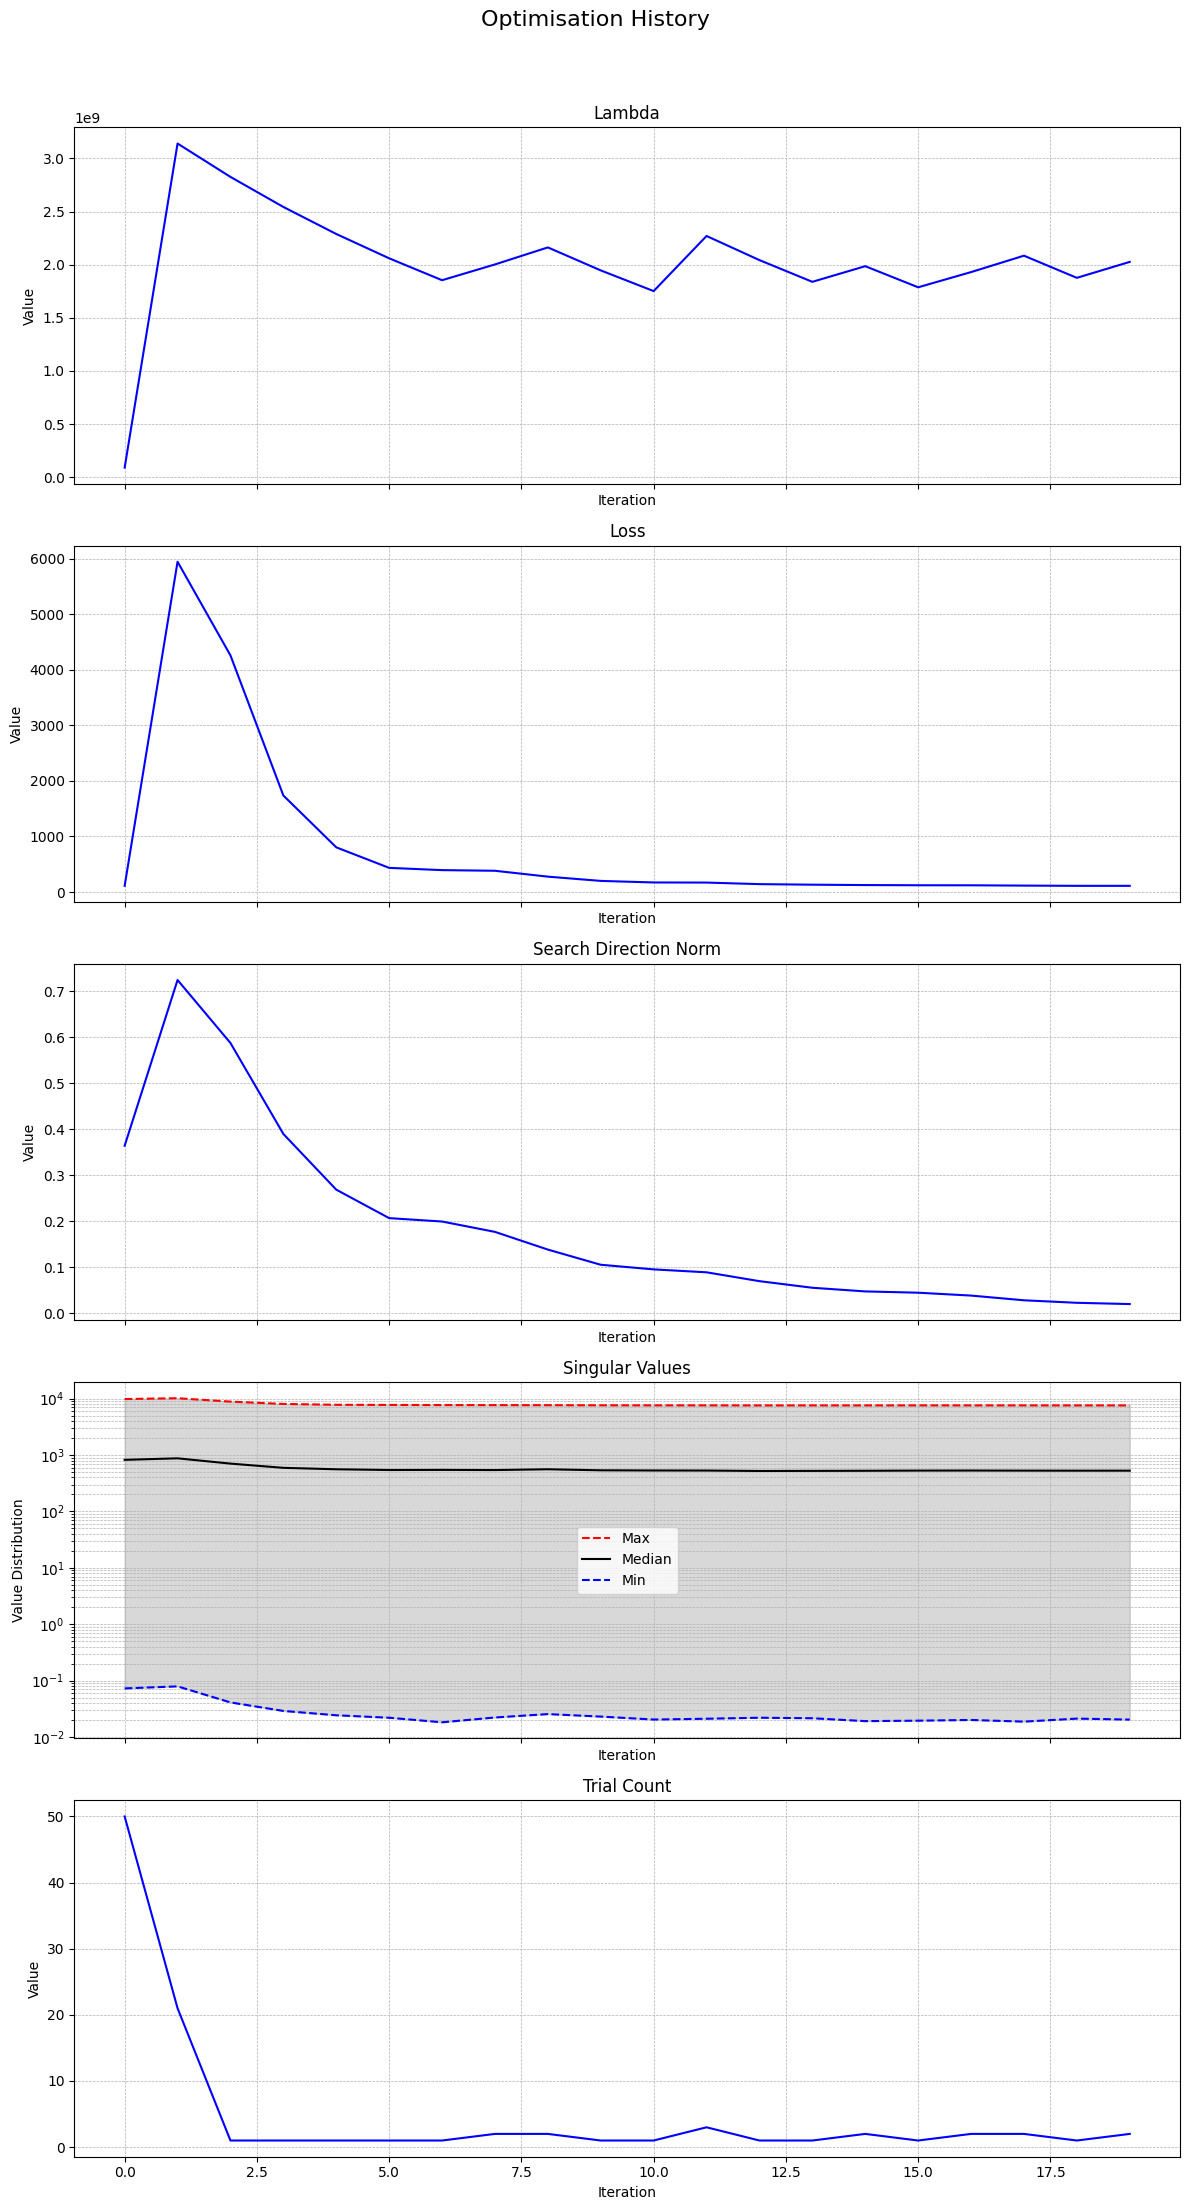

In [39]:
history.plot()